In [1]:
# %%
# autoreload
# %load_ext autoreload

# %autoreload 2
import math
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabModel, TabNetClassifier, TabNetRegressor
from sklearn.metrics import f1_score, precision_score, recall_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from app.constants import DATA_DIR, MODELS_DIR

In [2]:
# %%
activity_df = pd.read_parquet(DATA_DIR / "learning_activity.parquet")
print("Available columns:", list(activity_df.columns))

Available columns: ['learner_id', 'school_id', 'class_id', 'session_id', 'play_time', 'learning_unit', 'strand', 'outcome', 'foreground_duration', 'score', 'school_type', 'gender', 'grade', 'id']


 We have to be careful on which features we use for training. Not all of them would be available during prediction time.

 For example, when we want to predict a learner's score at a given session, we won't have its `outcome` and `foreground_duration`,

 only past ones. For this reason, we take extra care during our feature engineering to only calculate aggregates of

 these columns and past scores using samples from previous activities.



 In production, calculating these features would be done by a pipeline job on certain schedule and saved

 in a feature storage. They are then retrieved during inference time.

In [3]:
# %%
def _perform_feature_engineering(activity_df: pd.DataFrame):
    # Add aggregates of from earlier `play_times` to each row
    for row_index, row in activity_df.iterrows():
        play_time = row.play_time
        activity_df.loc[row_index, "play_time_hour"] = play_time.hour
        activity_df.loc[row_index, "play_time_weekday"] = play_time.weekday()

        # Adding learning unit-specific historical features
        past_activity_df = activity_df[activity_df.play_time < play_time]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_activity_df,
            row_index=row_index,
            col_prefix="unit_past",
        )

        # Adding learner-specific historical features, globally, by strand, and by learning unit.
        past_learner_activity_df = past_activity_df[past_activity_df.learner_id == row.learner_id]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_learner_activity_df,
            row_index=row_index,
            col_prefix="learner_past",
        )

        past_strand_activity_df = past_learner_activity_df[past_learner_activity_df.strand == row.strand]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_strand_activity_df,
            row_index=row_index,
            col_prefix="learner_past_strand",
        )

        past_learning_unit_activity_df = past_strand_activity_df[
            past_strand_activity_df.learning_unit == row.learning_unit
        ]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_learning_unit_activity_df,
            row_index=row_index,
            col_prefix="learner_past_learning_unit",
        )


def _add_agg_features_from_df(activity_df: pd.DataFrame, from_df: pd.DataFrame, row_index: int, col_prefix: str):
    for agg_function in ["mean", "min", "max"]:
        activity_df.loc[row_index, f"{col_prefix}_scores_{agg_function}"] = from_df.score.agg(agg_function)
        activity_df.loc[row_index, f"{col_prefix}_foreground_durations_{agg_function}"] = (
            from_df.foreground_duration.agg(agg_function)
        )

    for outcome in activity_df.outcome.unique():
        is_outcome = from_df.outcome == outcome

        outcome_count = is_outcome.sum()
        col_name = f"{col_prefix}_{outcome.lower()}_count"
        activity_df.loc[row_index, col_name] = outcome_count

        past_outcome_rate = outcome_count / (len(is_outcome) + 1e-6)
        col_name = f"{col_prefix}_{outcome.lower()}_rate"
        activity_df.loc[row_index, col_name] = past_outcome_rate

In [4]:
# %%
_perform_feature_engineering(activity_df)

categorical_columns = [
    "class_id",
    "school_id",
    "school_type",
    "learning_unit",
    "strand",
    "play_time_hour",
    "play_time_weekday",
    "gender",
    "grade",
]
numerical_columns = [column for column in activity_df.columns if "past_" in column]

 Before doing anything else, we keep a testing set to ensure there's no data leakage.

 Although we took care that data leakeage doesn't occur during feature engineering,

 any adjustments to the data that happen during modelin should only be performed on the training set.



 We use `play_time` as the splitting feature to be extra careful. Testing and validation sets each contain 10% of the samples.

In [5]:
# %%
def _split_dataset(activity_df: pd.DataFrame, test_split_datetime: pd.Timestamp, val_split_datetime: pd.Timestamp):
    train_activity_df = activity_df[activity_df.play_time < val_split_datetime]
    val_activity_df = activity_df[
        (activity_df.play_time >= val_split_datetime) & (activity_df.play_time < test_split_datetime)
    ]
    test_activity_df = activity_df[activity_df.play_time >= test_split_datetime]

    columns = ["learner_id", "class_id", "school_id", "school_type", "learning_unit", "strand", "grade"]
    for df in [val_activity_df, test_activity_df]:
        for column in columns:
            # print the number of unseen values in the test set
            print(f"Number of unseen `{column}` in the set: {len(set(df[column]) - set(train_activity_df[column]))}")
    return train_activity_df, val_activity_df, test_activity_df


astype_dict = {col: "category" for col in categorical_columns}
activity_df = activity_df.astype(astype_dict)

test_split_datetime = activity_df.play_time.quantile(0.9)
val_split_datetime = activity_df.play_time.quantile(0.8)
train_activity_df, val_activity_df, test_activity_df = _split_dataset(
    activity_df, test_split_datetime, val_split_datetime
)

Number of unseen `learner_id` in the set: 8
Number of unseen `class_id` in the set: 1
Number of unseen `school_id` in the set: 0
Number of unseen `school_type` in the set: 0
Number of unseen `learning_unit` in the set: 0
Number of unseen `strand` in the set: 0
Number of unseen `grade` in the set: 0
Number of unseen `learner_id` in the set: 13
Number of unseen `class_id` in the set: 2
Number of unseen `school_id` in the set: 1
Number of unseen `school_type` in the set: 0
Number of unseen `learning_unit` in the set: 0
Number of unseen `strand` in the set: 0
Number of unseen `grade` in the set: 0


 A few of the samples in the validation and testing set contain learners, classes, and schools not seen

 in the training set. This could cause problems because these are categorical features. XGBoost is capable

 of dealing with unseen categories but TabNet is not.

In [6]:
# %%
def _prepare_datasets(
    activity_dfs: list[pd.DataFrame],
    categorical_columns: list[str],
    numerical_columns: list[str],
    label_column: str,
):
    feature_columns = categorical_columns + numerical_columns
    astype_dict = {col: "category" for col in categorical_columns}
    features_and_labels = []
    for activity_df in activity_dfs:
        feature_df = activity_df[feature_columns].astype(astype_dict)
        labels = activity_df[label_column]
        features_and_labels.append((feature_df, labels))

    return features_and_labels


def _run_grid_search(
    xbg_model: xgb.XGBModel,
    param_grid: dict,
    train_feature_df: pd.DataFrame,
    val_feature_df: pd.DataFrame,
    train_labels: pd.Series,
    val_labels: pd.Series,
    scoring: str,
):
    clf = GridSearchCV(
        xbg_model,
        param_grid=param_grid,
        n_jobs=8,
        scoring=scoring,
        return_train_score=True,
    )
    eval_set = [
        (val_feature_df, val_labels),
    ]
    clf.fit(train_feature_df, train_labels, eval_set=eval_set, verbose=0)
    return clf

In [7]:
# %%
(train_feature_df, train_labels), (val_feature_df, val_labels), (test_feature_df, test_labels) = _prepare_datasets(
    [train_activity_df, val_activity_df, test_activity_df],
    categorical_columns,
    numerical_columns,
    label_column="score",
)

In [8]:
# %%
regressor = xgb.XGBRegressor(enable_categorical=True, validate_parameters=True)
param_grid = {
    "max_depth": [1, 2, 4],
    "subsample": [0.8],
    "min_child_weight": [0, 1],
    "gamma": [0, 0.2, 1, 5],
    "max_delta_step": [0, 1],
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.1],
    "tree_method": ["hist"],
}
param_combinations = math.prod([len(param) for param in param_grid.values()])
print(f"Number of combinations: {param_combinations}")
print(f"Estimated time: {param_combinations*2/60} minutes")

clf = _run_grid_search(
    xbg_model=regressor,
    param_grid=param_grid,
    train_feature_df=train_feature_df,
    val_feature_df=val_feature_df,
    train_labels=train_labels,
    val_labels=val_labels,
    scoring="neg_root_mean_squared_error",
)
print("best_params:", clf.best_params_)
regressor = clf.best_estimator_

Number of combinations: 144
Estimated time: 4.8 minutes
best_params: {'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 50, 'subsample': 0.8, 'tree_method': 'hist'}


In [9]:
# %%
train_pred_labels = regressor.predict(train_feature_df)
train_rmse = root_mean_squared_error(train_labels, train_pred_labels)
print(f"Training set RMSE: {train_rmse:0.3f}")

val_pred_labels = regressor.predict(val_feature_df)
val_rmse = root_mean_squared_error(val_labels, val_pred_labels)
print(f"Validation set RMSE: {val_rmse:0.3f}")

test_pred_labels = regressor.predict(test_feature_df)
test_rmse = root_mean_squared_error(test_labels, test_pred_labels)
print(f"Testing set RMSE: {test_rmse:0.3f}")

Training set RMSE: 0.214
Validation set RMSE: 0.341
Testing set RMSE: 0.325


 It seems the model is overfitting.

 Using the cv_results, we can dig deeper into the correlation between the hyperparameters and the scores.

 Given more time, we could go into further hyperparameter tuning but the improvement seems limited

 given that the lowest training RMSE is still high.

 With this high RMSE, we can see the model struggles to predict an accurate score for a student

 given its historical activity. With XGBoost, we can see the importance of each feature to the model.

 We look at the "gain" score of each feature. In practice, "gain" is often more informative than "weight"

 as it provides a deeper insight into how much a feature contributes to enhancing the model's predictions,

 making it a good choice for most  to understand how effective it is.

In [10]:
# %% Save the model for later use
regressor_path = Path(MODELS_DIR / "xgboost_regressor.json")
regressor_path.parent.mkdir(parents=True, exist_ok=True)
regressor.save_model(regressor_path)
df = pd.concat([train_activity_df, val_activity_df, test_activity_df])
df.to_parquet(DATA_DIR / "processed_learning_activity.parquet")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature Gain', ylabel='Features'>

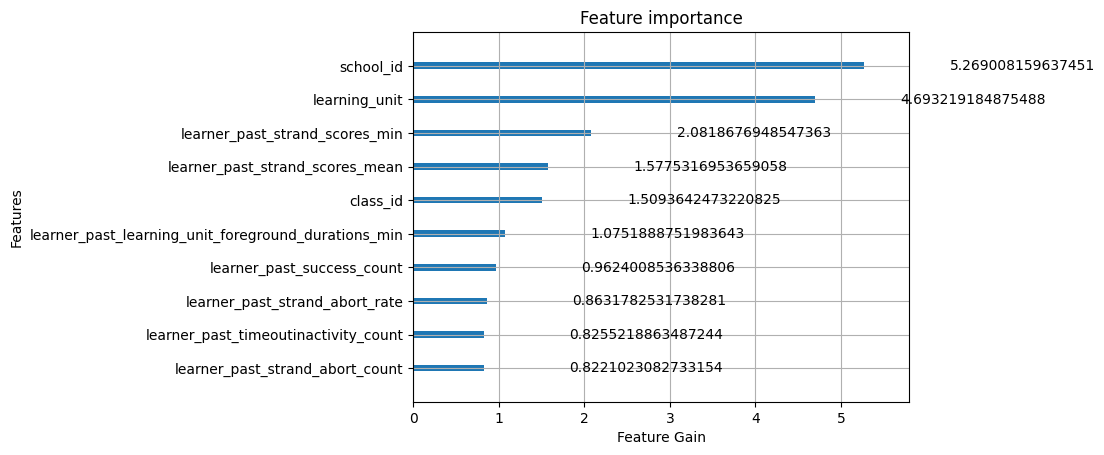

In [11]:
# %%
xgb.plot_importance(
    clf.best_estimator_.get_booster(),
    max_num_features=10,
    importance_type="gain",
    xlabel="Feature Gain",
)

 We see that the top 3 features with most gain are not related to the learning activity. In fact, `learning_unit`

 has the highest gain, meaning that the learning units themselves have more influence on a student's

 score than the student's current skill.



 Are there `learning_units` where the student's past performance is more indicative of their likely score?

In [12]:
# %%
for learning_unit in sorted(activity_df.learning_unit.unique()):
    lu_test_samples_index = test_feature_df[test_feature_df.learning_unit == learning_unit].index

    lu_test_feature_df = test_feature_df.loc[list(lu_test_samples_index)]
    lu_test_labels = test_labels.loc[list(lu_test_samples_index)]

    test_pred_labels = regressor.predict(lu_test_feature_df)
    test_rmse = root_mean_squared_error(lu_test_labels, test_pred_labels)
    print(f"learning_unit={learning_unit} (n={len(lu_test_labels)}) RMSE: {test_rmse:0.3f}")

learning_unit=OneCourse:OC_PhraseSentenceType.4dd8 (n=21) RMSE: 0.200
learning_unit=OneCourse:OC_PhraseSentenceType.5d44 (n=16) RMSE: 0.213
learning_unit=OneCourse:OC_PhraseSentenceType.5dd1 (n=48) RMSE: 0.232
learning_unit=OneCourse:OC_PhraseSentenceType.71cf (n=31) RMSE: 0.158
learning_unit=OneCourse:OC_PhraseSentenceType.7864 (n=69) RMSE: 0.238
learning_unit=OneCourse:OC_PhraseSentenceType.9b09 (n=17) RMSE: 0.244
learning_unit=OneCourse:OC_PhraseSentenceType.df02 (n=29) RMSE: 0.312
learning_unit=OneCourse:OC_TalkingHead.1dac (n=18) RMSE: 0.452
learning_unit=OneCourse:OC_TalkingHead.2360 (n=21) RMSE: 0.476
learning_unit=OneCourse:OC_TalkingHead.23de (n=25) RMSE: 0.503
learning_unit=OneCourse:OC_TalkingHead.3dba (n=15) RMSE: 0.278
learning_unit=OneCourse:OC_TalkingHead.5352 (n=26) RMSE: 0.349
learning_unit=OneCourse:OC_TalkingHead.5a16 (n=12) RMSE: 0.390
learning_unit=OneCourse:OC_TalkingHead.a5dd (n=19) RMSE: 0.476
learning_unit=OneCourse:OC_TalkingHead.ce7e (n=13) RMSE: 0.418


 We see that the RMSE for all Reading learning units are between 0.16 and 0.32,

 while the RMSE for all Listening learning units are between 0.26 and 0.44.

 The model is better at predicting Reading performance.

 It's worth mentioning that I've tried training two models, splitting the data by strand,

 but the results were similar to the combined model.

 ### Using TabNet

 TabNet is a deep learning model that promises to choose features depending on the sample.

 It's a good model to use when we have a lot of features and we want to avoid overfitting.

 TabNet cannot deal with unseen categories in the data. We have to make sure that the validation and testing set

 only contain categories that are present in the training set. Let's print the categories that don't fit this criteria.

 Throwing away data is not ideal given our small dataset. There are around 100 rows total from the validation and

 testing sets that contain unseen categories, dropping them would mean reducing each by ~15%.

 pick a random class_id from the training set

In [13]:
# %%
def _prepare_tabnet_datasets(
    train_activity_df: pd.DataFrame,
    val_activity_df: pd.DataFrame,
    test_activity_df: pd.DataFrame,
    categorical_columns: list[str],
    numerical_columns: list[str],
    label_column: str,
):

    (train_feature_df, train_labels), (val_feature_df, val_labels), (test_feature_df, test_labels) = _prepare_datasets(
        [train_activity_df, val_activity_df, test_activity_df],
        categorical_columns,
        numerical_columns,
        label_column=label_column,
    )

    train_feature_df = train_feature_df.copy()
    val_feature_df = val_feature_df.copy()
    test_feature_df = test_feature_df.copy()
    categorical_dims = {}
    for col in categorical_columns:
        label_encoder = LabelEncoder()
        # NOTE: we circumvent the issue of unseen values in the test set but
        # there are better ways to handle this.
        unique_values = pd.concat([train_feature_df[col], val_feature_df[col]]).unique()
        label_encoder.fit(unique_values)

        train_feature_df[col] = label_encoder.transform(train_feature_df[col].values)
        val_feature_df[col] = label_encoder.transform(val_feature_df[col].values)
        test_feature_df[col] = label_encoder.transform(test_feature_df[col].values)
        categorical_dims[col] = len(label_encoder.classes_)

    for col in numerical_columns:
        # NOTE: this should be looked at, as it might not be the best way to handle missing values
        train_feature_df = train_feature_df.fillna(-1, axis=1)
        val_feature_df = val_feature_df.fillna(-1, axis=1)
        test_feature_df = test_feature_df.fillna(-1, axis=1)

    return (
        (train_feature_df.values, train_labels.values),
        (val_feature_df.values, val_labels.values),
        (test_feature_df.values, test_labels.values),
    )


def _fit_tabnet(
    tabnet_model: TabModel,
    train_samples: np.array,
    val_samples: np.array,
    train_labels: np.array,
    val_labels: np.array,
    eval_metric: str,
    unsupervised_model: Optional[TabNetPretrainer] = None,
):
    eval_set = [
        (train_samples, train_labels),
        (val_samples, val_labels),
    ]
    tabnet_model.fit(
        train_samples,
        train_labels,
        eval_set=eval_set,
        eval_name=["train", "val"],
        eval_metric=[eval_metric],
        from_unsupervised=unsupervised_model,
    )

In [14]:
# %%
(train_samples, train_labels), (val_samples, val_labels), (test_samples, test_labels) = _prepare_tabnet_datasets(
    train_activity_df,
    val_activity_df,
    test_activity_df,
    categorical_columns=categorical_columns,
    numerical_columns=numerical_columns,
    label_column="score",
)

unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2), mask_type="entmax", verbose=0
)

unsupervised_model.fit(
    X_train=train_samples,
    eval_name=["train"],
    eval_set=[train_samples],
    max_epochs=1_000,
    pretraining_ratio=0.8,
)

ValueError: y contains previously unseen labels: 'c211ecb9c0f161385de70ec7cb018f12'

 If loss is below 1, according to the paper, the unsupervised model performs better

 than predicting the mean. We use it if that's the case.

In [ ]:
# %%
regressor = TabNetRegressor(verbose=0)
_fit_tabnet(
    tabnet_model=regressor,
    train_samples=train_samples,
    val_samples=val_samples,
    train_labels=train_labels.reshape(-1, 1),
    val_labels=val_labels.reshape(-1, 1),
    eval_metric="rmse",
    # unsupervised_model=unsupervised_model,
)

In [ ]:
# %%
train_pred_labels = regressor.predict(train_samples)
train_rmse = root_mean_squared_error(train_labels, train_pred_labels)
print(f"Training set RMSE: {train_rmse:0.3f}")

val_pred_labels = regressor.predict(val_samples)
val_rmse = root_mean_squared_error(val_labels, val_pred_labels)
print(f"Validation set RMSE: {val_rmse:0.3f}")

test_pred_labels = regressor.predict(test_samples)
test_rmse = root_mean_squared_error(test_labels, test_pred_labels)
print(f"Testing set RMSE: {test_rmse:0.3f}")

 TabNet is not fitting the data well. The training, validation, and testing RMSE are all high and close to each other.

 XGBoost beats TabNet by 2% in RMSE, so from the results we have, we would choose XGBoost.

 ## Reframing as a classification problem



 Let's see if we can get better performance if we reframe the problem as a classification task.

 We divide the scores into bins that the model will predict for a given sample.

 If we can show that a model can predict a student's score as a range, then we can use this information more reliably.



 Let's check the score distribution to see how we can divide the scores into bins.

In [ ]:
# %%
activity_df.score.hist(bins=30)

 Let's also check the distribution of the scores by dataset split.

In [ ]:
# %%
val_activity_df.score.hist(bins=30)

In [ ]:
# %%
test_activity_df.score.hist(bins=30)

 Due to time constraints, I decided to "balance" the labels by equal-sized bins using `np.qcut`.

 This is a quick way to balance the labels according to their distribution.

 If we would only do a uniform range of `[0, 1]`, there will be a significant imbalance.

 If we see good performance of the classification model, then we can invest more time on correctly

 balancing the dataset through resampling techniques and specifying sample weights.



 We only use the training set to determine the bins and apply them to the validation and testing sets.

In [ ]:
# %%
num_bins = 4

score_bins, bins = pd.qcut(train_activity_df.score, num_bins, retbins=True, labels=False)
bin_labels = [f"{bin_min:0.2f}-{bin_max:0.2f}" for bin_min, bin_max in zip(bins[:-1], bins[1:])]

train_activity_df = train_activity_df.assign(score_bin=score_bins)
print("Training label distribution:")
train_activity_df.score_bin.value_counts()

In [ ]:
# %%
# Apply the bins to the validation and testing sets
val_activity_df = val_activity_df.assign(
    score_bin=pd.cut(val_activity_df.score, bins=bins, include_lowest=True, labels=False)
)
print("Validation label distribution:")
val_activity_df.score_bin.value_counts()

In [ ]:
# %%
test_activity_df = test_activity_df.assign(
    score_bin=pd.cut(test_activity_df.score, bins=bins, include_lowest=True, labels=False)
)
print("Testing label distribution:")
test_activity_df.score_bin.value_counts()

 The validation and testing set end up having different distributions of the labels.

 But we can tolerate this for now, as long as they correctly evaluate the model's performance.



 Choosing the parameter grid took some tuning because the model was overfitting strongly.

 I restricted `max_depth` and `n_estimators` and let it explore other hyperparameters.

In [ ]:
# %%

(train_feature_df, train_labels), (val_feature_df, val_labels), (test_feature_df, test_labels) = _prepare_datasets(
    [train_activity_df, val_activity_df, test_activity_df],
    categorical_columns,
    numerical_columns,
    label_column="score_bin",
)
classifier = xgb.XGBClassifier(enable_categorical=True, validate_parameters=True)
param_grid = {
    "max_depth": [1, 2],  # low values prevent overfitting
    "n_estimators": [10, 50],  # low values prevent overfitting
    "subsample": [0.8],
    "min_child_weight": [0, 1, 2, 5, 10, 20],  # high values prevent overfitting
    "gamma": [0, 0.2, 1, 2, 5, 10],  # high values prevent overfitting
    "learning_rate": [0.05, 0.1],
    "max_bin": [128],
    "max_cat_to_onehot": [5],
}
param_combinations = math.prod([len(param) for param in param_grid.values()])
print(f"Number of combinations: {param_combinations}")
print(f"Estimated time: {param_combinations*2/60} minutes")

clf = _run_grid_search(
    xbg_model=classifier,
    param_grid=param_grid,
    train_feature_df=train_feature_df,
    val_feature_df=val_feature_df,
    train_labels=train_labels,
    val_labels=val_labels,
    scoring="f1_weighted",
)
print("best_params:", clf.best_params_)
classifier = clf.best_estimator_

xgb.plot_importance(
    clf.best_estimator_.get_booster(),
    max_num_features=10,
    importance_type="gain",
    xlabel="Feature Gain",
)

In [ ]:
# %%
cv_result_df = pd.DataFrame(clf.cv_results_)
param_columns = [
    column for column in cv_result_df.columns if column.startswith("param_") and column != "param_tree_method"
]
score_columns = ["mean_train_score", "mean_test_score"]
cv_result_df[[*param_columns, *score_columns]].corr()[score_columns]

In [ ]:
# %%
def _print_classification_metrics(pred_labels, true_labels, label_names, split_name):
    precision = precision_score(true_labels, pred_labels, average=None)
    recall = recall_score(true_labels, pred_labels, average=None)
    f1_weighted = f1_score(true_labels, pred_labels, average="weighted")

    label_names = np.array(label_names)[np.unique(true_labels)]
    print(f"{split_name} precision for each label:")
    print(pd.DataFrame(precision, index=label_names, columns=["precision"]))
    print(f"{split_name} recall for each label:")
    print(pd.DataFrame(recall, index=label_names, columns=["recall"]))
    print(f"{split_name} f1-score weighted:", f1_weighted)
    print()


for feature_df, true_labels, name in [
    (train_feature_df, train_labels, "train"),
    (val_feature_df, val_labels, "val"),
    (test_feature_df, test_labels, "test"),
]:
    pred_labels = classifier.predict(feature_df)
    _print_classification_metrics(pred_labels, true_labels, label_names=bin_labels, split_name=name)

 Train and validation RMSE are close, which means we are not overfitting but, similar to the regression model,

 classification performance is not great. Let's see if any of the learning units has particular good performance.

 ### TabNet as a classifier

 unsupervised_model=unsupervised_model,

In [ ]:
# %%

for feature_df, true_labels, name in [
    (train_samples, train_labels, "train"),
    (val_samples, val_labels, "val"),
    (test_samples, test_labels, "test"),
]:
    pred_labels = classifier.predict(feature_df)
    _print_classification_metrics(pred_labels, true_labels, label_names=bin_labels, split_name=name)

 TabNet as a classifier still does not beat XGBoost. Authors of the model claim it consistenly outperforms it.

 There was not enough time to tune the model further, but it's possible that with more time, TabNet could outperform XGBoost.

In [ ]:
# %%